In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for statistical analysis
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the dataset.
file_path = 'diabetes_medication_clinical_trial1_3.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' loaded successfully into DataFrame.")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
    print("Please ensure the CSV file is in the same directory as this Jupyter notebook,")
    print("or provide the correct, full path to the file.")
    raise # 


print("\n--- Initial data overview ---")

# Display the first 5 rows of the DataFrame.
print("\nFirst 5 rows of the dataset (df.head()):")
print(df.head())

# Get a concise summary of the DataFrame.
print("\nDataFrame Information (df.info()):")
df.info()

# Generate descriptive statistics for numerical columns.
print("\nDescriptive statistics of numerical columns (df.describe()):")
print(df.describe())

# Check the number of missing values in each column.
print("\nNumber of missing values in each column (df.isnull().sum()):")
print(df.isnull().sum())

Dataset 'diabetes_medication_clinical_trial1_3.csv' loaded successfully into DataFrame.

--- Initial data overview ---

First 5 rows of the dataset (df.head()):
   subject_id      group  age  gender  duration_diabetes  initial_hba1c  \
0           1  treatment   70  Female                 10            8.7   
1           2    placebo   46    Male                 19            9.9   
2           3  treatment   56    Male                 17            8.6   
3           4  treatment   59    Male                 19            8.9   
4           5  treatment   68    Male                  5            9.1   

   hba1c  time adverse_event  
0    8.7     0           NaN  
1    9.9     0       Fatigue  
2    8.6     0           NaN  
3    8.9     0      Headache  
4    9.1     0           NaN  

DataFrame Information (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------ 

In [2]:
# Data Cleaning & Preprocessing

print("\n--- Data Cleaning & Preprocessing ---")

# 1. Handle Missing Values in 'adverse_event'
df['adverse_event'] = df['adverse_event'].fillna('None')
print("\nMissing values in 'adverse_event' column filled with 'None'.")

# Verify that there are no more missing values
print("\nNumber of missing values after handling (df.isnull().sum()):")
print(df.isnull().sum())

# 2. Convert 'group' and 'gender' to 'category' dtype
df['group'] = df['group'].astype('category')
df['gender'] = df['gender'].astype('category')
print("\n'group' and 'gender' columns converted to 'category' dtype.")
print("\nDataFrame Info after type conversions (df.info()):")
df.info()

# 3. Create 'final_hba1c' for each subject (HbA1c level at time=24)
final_hba1c_df = df[df['time'] == 24][['subject_id', 'hba1c']].copy() 
print("\n'final_hba1c_df' created, containing HbA1c levels at time=24.")
print(final_hba1c_df.head())

# 4. Calculate 'change_hba1c' (initial_hba1c - final_hba1c)
initial_hba1c_df = df[df['time'] == 0][['subject_id', 'initial_hba1c', 'gender', 'age', 'group', 'duration_diabetes']].drop_duplicates().copy()

# Merge final_hba1c with initial_hba1c to calculate the change.
merged_hba1c = pd.merge(initial_hba1c_df, final_hba1c_df[['subject_id', 'hba1c']],
                        on='subject_id', how='inner')

merged_hba1c.rename(columns={'hba1c': 'final_hba1c'}, inplace=True)

merged_hba1c['change_hba1c'] = merged_hba1c['initial_hba1c'] - merged_hba1c['final_hba1c']

print("\n'change_hba1c' calculated for each subject:")
print(merged_hba1c.head())
print(f"\nNumber of subjects with calculated change_hba1c: {len(merged_hba1c)}")


--- Data Cleaning & Preprocessing ---

Missing values in 'adverse_event' column filled with 'None'.

Number of missing values after handling (df.isnull().sum()):
subject_id           0
group                0
age                  0
gender               0
duration_diabetes    0
initial_hba1c        0
hba1c                0
time                 0
adverse_event        0
dtype: int64

'group' and 'gender' columns converted to 'category' dtype.

DataFrame Info after type conversions (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   subject_id         1400 non-null   int64   
 1   group              1400 non-null   category
 2   age                1400 non-null   int64   
 3   gender             1400 non-null   category
 4   duration_diabetes  1400 non-null   int64   
 5   initial_hba1c      1400 non-null   float64 
 6   h

In [3]:
#  Statistical Analysis - T-test for Final HbA1c

print("\n--- Step 3: Statistical Analysis - T-test for Final HbA1c ---")

# Question 1: Is the new medication effective in reducing hba1c levels compared to the placebo?

# Separate the data for treatment and placebo groups based on 'final_hba1c'.
treatment_hba1c = merged_hba1c[merged_hba1c['group'] == 'treatment']['final_hba1c']
placebo_hba1c = merged_hba1c[merged_hba1c['group'] == 'placebo']['final_hba1c']

print("\nDescriptive statistics for final HbA1c by group:")
print(f"Treatment Group (n={len(treatment_hba1c)}): Mean = {treatment_hba1c.mean():.2f}, Std = {treatment_hba1c.std():.2f}")
print(f"Placebo Group (n={len(placebo_hba1c)}): Mean = {placebo_hba1c.mean():.2f}, Std = {placebo_hba1c.std():.2f}")

# Perform an independent samples t-test.
t_stat, p_value = stats.ttest_ind(treatment_hba1c, placebo_hba1c, equal_var=False) 

print(f"\nIndependent t-test comparing final HbA1c levels:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpret the p-value.
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Since p-value ({p_value:.3f}) is less than alpha ({alpha}),")
    print("we reject the null hypothesis. There is a statistically significant difference")
    print("in final HbA1c levels between the treatment and placebo groups.")
    if treatment_hba1c.mean() < placebo_hba1c.mean():
        print("The treatment group has a significantly lower final HbA1c, suggesting the new medication is effective.")
    else:
        print("The placebo group has a significantly lower final HbA1c.")
else:
    print(f"\nConclusion: Since p-value ({p_value:.3f}) is greater than or equal to alpha ({alpha}),")
    print("we fail to reject the null hypothesis. There is no statistically significant difference")
    print("in final HbA1c levels between the treatment and placebo groups.")

print("\n--- End of T-test Analysis ---")


--- Step 3: Statistical Analysis - T-test for Final HbA1c ---

Descriptive statistics for final HbA1c by group:
Treatment Group (n=100): Mean = 6.13, Std = 0.93
Placebo Group (n=100): Mean = 7.69, Std = 0.80

Independent t-test comparing final HbA1c levels:
T-statistic: -12.681
P-value: 0.000

Conclusion: Since p-value (0.000) is less than alpha (0.05),
we reject the null hypothesis. There is a statistically significant difference
in final HbA1c levels between the treatment and placebo groups.
The treatment group has a significantly lower final HbA1c, suggesting the new medication is effective.

--- End of T-test Analysis ---



--- Step 4.1: Visualizing HbA1c Levels Over Time ---


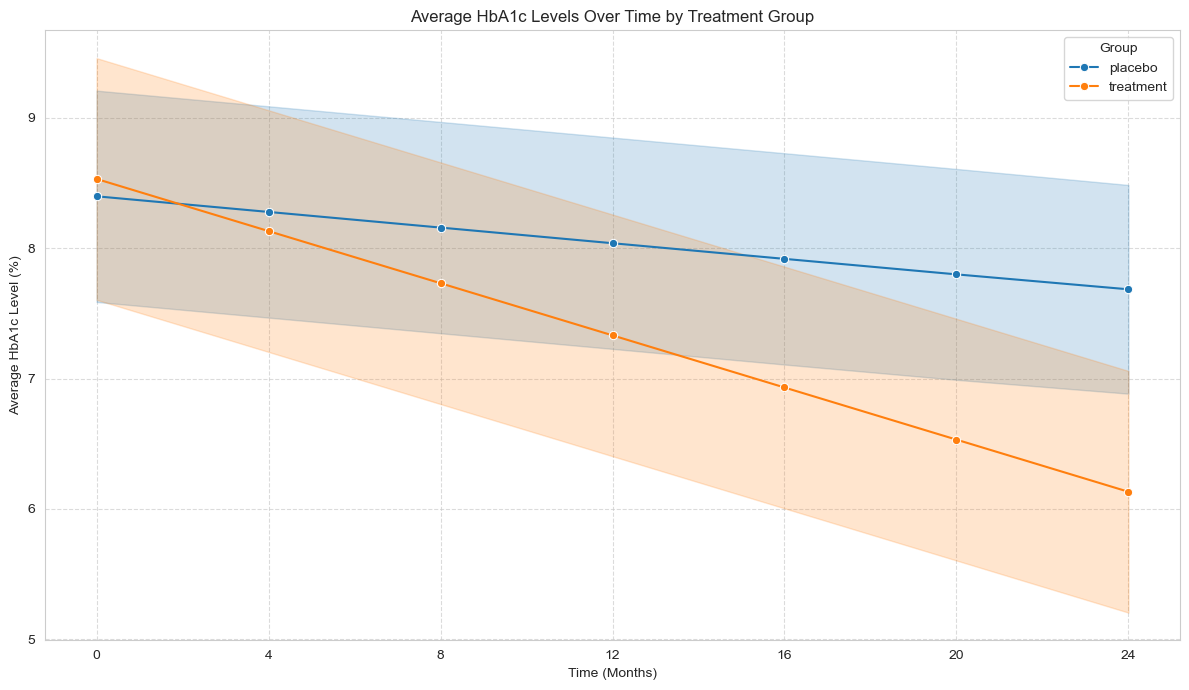

Line plot showing average HbA1c levels over time generated successfully.


In [4]:
# Data Visualization - Line Plot of HbA1c Over Time

print("\n--- Step 4.1: Visualizing HbA1c Levels Over Time ---")

sns.set_style("whitegrid")

# Create a line plot showing hba1c levels over time for both treatment and placebo groups.
plt.figure(figsize=(12, 7)) 
sns.lineplot(data=df, x='time', y='hba1c', hue='group', marker='o', errorbar='sd') 
plt.title('Average HbA1c Levels Over Time by Treatment Group')
plt.xlabel('Time (Months)')
plt.ylabel('Average HbA1c Level (%)')
plt.xticks(df['time'].unique()) 
plt.legend(title='Group') 
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

print("Line plot showing average HbA1c levels over time generated successfully.")



--- Step 4.2: Visualizing Final HbA1c Levels by Group ---


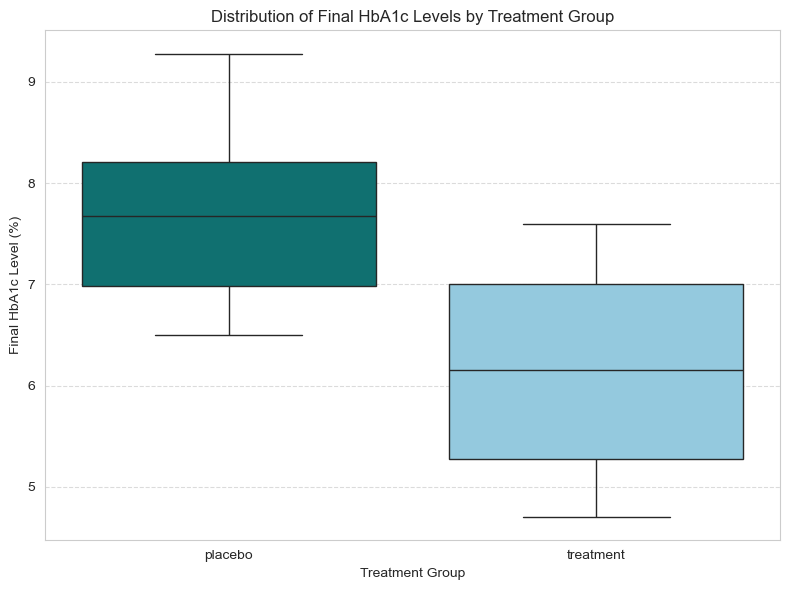

Box plot comparing final HbA1c levels generated successfully.


In [5]:
# Data Visualization - Box Plot Comparing Final HbA1c Levels

print("\n--- Step 4.2: Visualizing Final HbA1c Levels by Group ---")

# Set a professional style for plots.
sns.set_style("whitegrid")

# Create a box plot comparing final HbA1c levels between treatment and placebo groups.
plt.figure(figsize=(8, 6)) 
sns.boxplot(x='group', y='final_hba1c', data=merged_hba1c, hue='group', palette={'treatment': 'skyblue', 'placebo': 'teal'}, legend=False)
plt.title('Distribution of Final HbA1c Levels by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Final HbA1c Level (%)')
plt.grid(True, linestyle='--', alpha=0.7, axis='y') 
plt.tight_layout() 
plt.show()

print("Box plot comparing final HbA1c levels generated successfully.")


--- Step 4.3: Visualizing Most Common Adverse Events ---


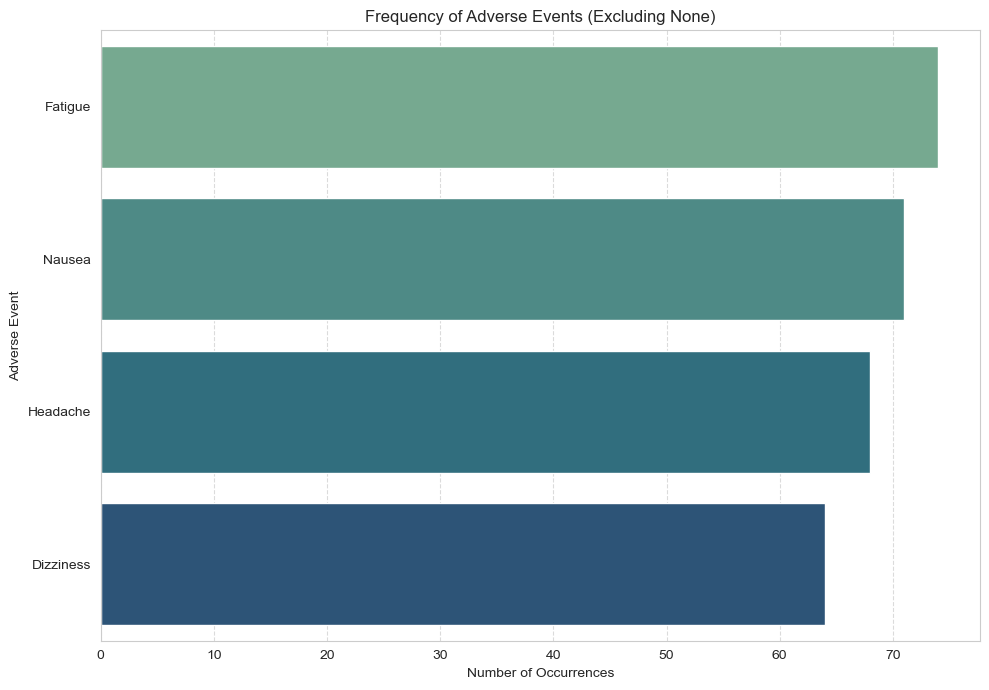

Bar chart of most common adverse events generated successfully.


In [6]:
# Data Visualization - Bar Chart of Most Common Adverse Events

print("\n--- Step 4.3: Visualizing Most Common Adverse Events ---")

# Set a professional style for plots.
sns.set_style("whitegrid")

# Calculate the frequency of each adverse event.
adverse_event_counts = df[df['adverse_event'] != 'None']['adverse_event'].value_counts()

# Select the top N most common adverse events to display for better readability.
top_adverse_events = adverse_event_counts

plt.figure(figsize=(10, 7))

sns.barplot(x=top_adverse_events.values, y=top_adverse_events.index, hue=top_adverse_events.index, palette='crest', legend=False)
plt.title('Frequency of Adverse Events (Excluding None)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Adverse Event')
plt.grid(True, linestyle='--', alpha=0.7, axis='x') 
plt.tight_layout() 
plt.show()

print("Bar chart of most common adverse events generated successfully.")


--- Step 4.4: Visualizing Initial HbA1c vs. Change in HbA1c ---


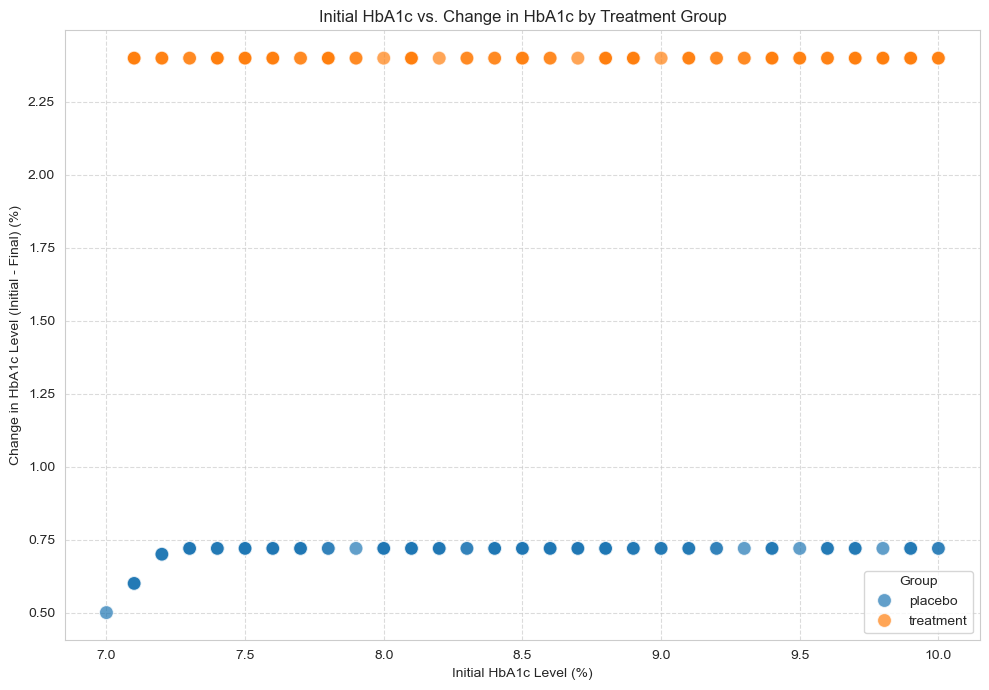

Scatter plot of Initial HbA1c vs. Change in HbA1c generated successfully.


In [7]:
# Data Visualization - Scatter Plot of Initial HbA1c vs. Change in HbA1c

print("\n--- Step 4.4: Visualizing Initial HbA1c vs. Change in HbA1c ---")

sns.set_style("whitegrid")

# Create a scatter plot.
# 'x' will be 'initial_hba1c', and 'y' will be 'change_hba1c'.
plt.figure(figsize=(10, 7)) 
sns.scatterplot(x='initial_hba1c', y='change_hba1c', hue='group', data=merged_hba1c, s=100, alpha=0.7)
plt.title('Initial HbA1c vs. Change in HbA1c by Treatment Group')
plt.xlabel('Initial HbA1c Level (%)')
plt.ylabel('Change in HbA1c Level (Initial - Final) (%)') 
plt.grid(True, linestyle='--', alpha=0.7) 
plt.legend(title='Group')
plt.tight_layout() 
plt.show()

print("Scatter plot of Initial HbA1c vs. Change in HbA1c generated successfully.")


In [14]:
# Statistical Analysis - Repeated Measures ANOVA for HbA1c Changes Over Time

print("\n--- Step 5: Repeated Measures ANOVA for HbA1c Changes Over Time ---")


df['subject_id_cat'] = df['subject_id'].astype('category')

# Define the model formula for assessing the effect of group, time, and their interaction on hba1c.

formula = 'hba1c ~ C(group) * C(time)'

# Fit the ANOVA model using statsmodels' Ordinary Least Squares and then calculate ANOVA table.
model_ols = ols(formula, data=df).fit() 
anova_table = sm.stats.anova_lm(model_ols, typ=2) 

print("\nANOVA Summary:")
print(anova_table)

print("\n--- End of Repeated Measures ANOVA Analysis ---")


--- Step 5: Repeated Measures ANOVA for HbA1c Changes Over Time ---

ANOVA Summary:
                       sum_sq      df           F        PR(>F)
C(group)           175.470721     1.0  231.776624  1.630845e-48
C(time)            377.459307     6.0   83.096716  5.610526e-89
C(group):C(time)   110.355307     6.0   24.294443  1.797144e-27
Residual          1049.296584  1386.0         NaN           NaN

--- End of Repeated Measures ANOVA Analysis ---


In [9]:
# Statistical Analysis - Chi-square Test for Adverse Event Rates

print("\n--- Step 6: Chi-square Test for Adverse Event Rates ---")

# Question 3: What is the safety profile of the new medication? Are there any concerning adverse events?

df['has_specific_adverse_event'] = (df['adverse_event'] != 'None')

subject_adverse_event_status = df.groupby(['subject_id', 'group'], observed=False)['has_specific_adverse_event'].any().reset_index()

subject_adverse_event_status.rename(columns={'has_specific_adverse_event': 'had_any_adverse_event'}, inplace=True)

# Create a contingency table (cross-tabulation) of 'group' vs 'had_any_adverse_event'.
contingency_table = pd.crosstab(subject_adverse_event_status['group'], subject_adverse_event_status['had_any_adverse_event'])

print("\nContingency Table (Group vs. Had Any Adverse Event):")
print(contingency_table)

# Perform the Chi-square test.
chi2, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

print(f"\nChi-square test comparing adverse event rates between groups:")
print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected Frequencies (if no association):")
print(expected_freq)

# Interpret the p-value.
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Since p-value ({p_value:.3f}) is less than alpha ({alpha}),")
    print("we reject the null hypothesis. There is a statistically significant difference")
    print("in the rate of adverse events between the treatment and placebo groups.")
    event_rates = contingency_table.apply(lambda r: r / r.sum(), axis=1) * 100
    print("\nPercentage of subjects with any adverse event by group:")
    print(event_rates)
    if event_rates.loc['treatment', True] > event_rates.loc['placebo', True]:
        print("The treatment group has a higher rate of adverse events.")
    else:
        print("The placebo group has a higher rate of adverse events.")
else:
    print(f"\nConclusion: Since p-value ({p_value:.3f}) is greater than or equal to alpha ({alpha}),")
    print("we fail to reject the null hypothesis. There is no statistically significant difference")
    print("in the rate of adverse events between the treatment and placebo groups.")

print("\n--- End of Chi-square Test Analysis ---")



--- Step 6: Chi-square Test for Adverse Event Rates ---

Contingency Table (Group vs. Had Any Adverse Event):
had_any_adverse_event  False  True 
group                              
placebo                   20     80
treatment                 24     76

Chi-square test comparing adverse event rates between groups:
Chi-square statistic: 0.262
P-value: 0.609
Degrees of freedom: 1

Expected Frequencies (if no association):
[[22. 78.]
 [22. 78.]]

Conclusion: Since p-value (0.609) is greater than or equal to alpha (0.05),
we fail to reject the null hypothesis. There is no statistically significant difference
in the rate of adverse events between the treatment and placebo groups.

--- End of Chi-square Test Analysis ---


In [10]:
# Bonus Challenge: Effectiveness by Gender

print("\n--- Bonus Challenge: Effectiveness by Gender ---")

# Question: Is the medication’s effectiveness different based on gender?

# descriptive statistics for change_hba1c by group and gender.
print("\nDescriptive statistics for Change in HbA1c by Group and Gender:")
gender_effectiveness_stats = merged_hba1c.groupby(['group', 'gender'], observed=False)['change_hba1c'].agg(['mean', 'std', 'count'])
print(gender_effectiveness_stats)

# Separate data for males and females in the treatment group
treatment_males = merged_hba1c[(merged_hba1c['group'] == 'treatment') & (merged_hba1c['gender'] == 'Male')]['change_hba1c']
treatment_females = merged_hba1c[(merged_hba1c['group'] == 'treatment') & (merged_hba1c['gender'] == 'Female')]['change_hba1c']

# Perform t-test for treatment group (Males vs Females)
if len(treatment_males) > 1 and len(treatment_females) > 1:
    t_stat_trt_gender, p_value_trt_gender = stats.ttest_ind(treatment_males, treatment_females, equal_var=False)
    print(f"\n--- T-test for Change in HbA1c (Treatment Group: Male vs. Female) ---")
    print(f"T-statistic: {t_stat_trt_gender:.3f}")
    print(f"P-value: {p_value_trt_gender:.3f}")
    if p_value_trt_gender < 0.05:
        print("Conclusion: Statistically significant difference in change_hba1c between genders in treatment group.")
        if treatment_males.mean() > treatment_females.mean():
            print("Males in treatment group show greater HbA1c reduction.")
        else:
            print("Females in treatment group show greater HbA1c reduction.")
    else:
        print("Conclusion: No statistically significant difference in change_hba1c between genders in treatment group.")
else:
    print("\nNot enough data to perform t-test for treatment group by gender.")


# Separate data for males and females in the placebo group
placebo_males = merged_hba1c[(merged_hba1c['group'] == 'placebo') & (merged_hba1c['gender'] == 'Male')]['change_hba1c']
placebo_females = merged_hba1c[(merged_hba1c['group'] == 'placebo') & (merged_hba1c['gender'] == 'Female')]['change_hba1c']

# Perform t-test for placebo group (Males vs Females)
if len(placebo_males) > 1 and len(placebo_females) > 1: 
    t_stat_plc_gender, p_value_plc_gender = stats.ttest_ind(placebo_males, placebo_females, equal_var=False)
    print(f"\n--- T-test for Change in HbA1c (Placebo Group: Male vs. Female) ---")
    print(f"T-statistic: {t_stat_plc_gender:.3f}")
    print(f"P-value: {p_value_plc_gender:.3f}")
    if p_value_plc_gender < 0.05:
        print("Conclusion: Statistically significant difference in change_hba1c between genders in placebo group.")
        if placebo_males.mean() > placebo_females.mean():
            print("Males in placebo group show greater HbA1c reduction.")
        else:
            print("Females in placebo group show greater HbA1c reduction.")
    else:
        print("Conclusion: No statistically significant difference in change_hba1c between genders in placebo group.")
else:
    print("\nNot enough data to perform t-test for placebo group by gender.")

print("\n--- End of Effectiveness by Gender Analysis ---")



--- Bonus Challenge: Effectiveness by Gender ---

Descriptive statistics for Change in HbA1c by Group and Gender:
                      mean           std  count
group     gender                               
placebo   Female  0.714583  2.431691e-02     48
          Male    0.712692  3.453418e-02     52
treatment Female  2.400000  3.243169e-16     61
          Male    2.400000  0.000000e+00     39

--- T-test for Change in HbA1c (Treatment Group: Male vs. Female) ---
T-statistic: 0.000
P-value: 1.000
Conclusion: No statistically significant difference in change_hba1c between genders in treatment group.

--- T-test for Change in HbA1c (Placebo Group: Male vs. Female) ---
T-statistic: -0.318
P-value: 0.751
Conclusion: No statistically significant difference in change_hba1c between genders in placebo group.

--- End of Effectiveness by Gender Analysis ---


C:\Users\Dell\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
# Effectiveness by Age Groups

print("\n--- Bonus Challenge: Effectiveness by Age Groups ---")

# Question: Is the medication’s effectiveness different based on age groups?

# 1. Define Age Bins/Categories.
# create 3 age groups: 40-50, 51-60, 61-70.
bins = [40, 50, 60, 70]
labels = ['40-50', '51-60', '61-70'] # Labels for the age groups

# Create a new column 'age_group' in the merged_hba1c DataFrame.
merged_hba1c['age_group'] = pd.cut(merged_hba1c['age'], bins=bins, labels=labels, right=True, include_lowest=True)

print("\nDataFrame with Age Groups (first 5 rows):")
print(merged_hba1c.head())

# 2. Get descriptive statistics for change_hba1c by group and age_group.
print("\nDescriptive statistics for Change in HbA1c by Group and Age Group:")
age_effectiveness_stats = merged_hba1c.groupby(['group', 'age_group'], observed=False)['change_hba1c'].agg(['mean', 'std', 'count'])
print(age_effectiveness_stats)


# Data for Treatment Group
treatment_data = merged_hba1c[merged_hba1c['group'] == 'treatment']
# Data for Placebo Group
placebo_data = merged_hba1c[merged_hba1c['group'] == 'placebo']

# Check if there's enough data for each group
if not treatment_data['age_group'].value_counts().min() > 1:
    print("\nNot enough data points per age group in the Treatment group for ANOVA.")
else:
    print("\n--- ANOVA for Change in HbA1c (Treatment Group by Age Group) ---")
    model_trt = ols('change_hba1c ~ C(age_group)', data=treatment_data).fit()
    anova_table_trt = sm.stats.anova_lm(model_trt, typ=2)
    print(anova_table_trt)
    if 'C(age_group)' in anova_table_trt.index and anova_table_trt.loc['C(age_group)', 'PR(>F)'] < 0.05:
        print("Conclusion: Statistically significant difference in change_hba1c across age groups in treatment group.")
    else:
        print("Conclusion: No statistically significant difference in change_hba1c across age groups in treatment group.")


if not placebo_data['age_group'].value_counts().min() > 1:
    print("\nNot enough data points per age group in the Placebo group for ANOVA.")
else:
    print("\n--- ANOVA for Change in HbA1c (Placebo Group by Age Group) ---")
    model_plc = ols('change_hba1c ~ C(age_group)', data=placebo_data).fit()
    anova_table_plc = sm.stats.anova_lm(model_plc, typ=2)
    print(anova_table_plc)
    if 'C(age_group)' in anova_table_plc.index and anova_table_plc.loc['C(age_group)', 'PR(>F)'] < 0.05:
        print("Conclusion: Statistically significant difference in change_hba1c across age groups in placebo group.")
    else:
        print("Conclusion: No statistically significant difference in change_hba1c across age groups in placebo group.")

print("\n--- End of Effectiveness by Age Groups Analysis ---")



--- Bonus Challenge: Effectiveness by Age Groups ---

DataFrame with Age Groups (first 5 rows):
   subject_id  initial_hba1c  gender  age      group  duration_diabetes  \
0           1            8.7  Female   70  treatment                 10   
1           2            9.9    Male   46    placebo                 19   
2           3            8.6    Male   56  treatment                 17   
3           4            8.9    Male   59  treatment                 19   
4           5            9.1    Male   68  treatment                  5   

   final_hba1c  change_hba1c age_group  
0         6.30          2.40     61-70  
1         9.18          0.72     40-50  
2         6.20          2.40     51-60  
3         6.50          2.40     51-60  
4         6.70          2.40     61-70  

Descriptive statistics for Change in HbA1c by Group and Age Group:
                         mean           std  count
group     age_group                               
placebo   40-50      0.712632  2.728

In [13]:
# Bonus Challenge: Correlation between Duration of Diabetes and HbA1c Reduction

print("\n--- Bonus Challenge: Correlation - Duration of Diabetes vs. HbA1c Reduction ---")

# Question: Is there a correlation between the duration of diabetes and the medication’s effectiveness?

# 1. Calculate Pearson correlation coefficient.

# For Treatment Group
treatment_duration = merged_hba1c[merged_hba1c['group'] == 'treatment']['duration_diabetes']
treatment_change_hba1c = merged_hba1c[merged_hba1c['group'] == 'treatment']['change_hba1c']

# Calculate Pearson correlation (r value) and p-value.
r_trt, p_value_trt = stats.pearsonr(treatment_duration, treatment_change_hba1c)

print(f"\n--- Correlation (Treatment Group: Duration of Diabetes vs. Change in HbA1c) ---")
print(f"Pearson Correlation Coefficient (r): {r_trt:.3f}")
print(f"P-value: {p_value_trt:.3f}")
if p_value_trt < 0.05:
    print(f"Conclusion: There is a statistically significant correlation between duration of diabetes and HbA1c reduction.")
    if r_trt > 0:
        print("A positive correlation means longer duration is associated with greater reduction.")
    else:
        print("A negative correlation means longer duration is associated with smaller reduction.")
else:
    print("Conclusion: No statistically significant correlation between duration of diabetes and HbA1c reduction.")


# For Placebo Group
placebo_duration = merged_hba1c[merged_hba1c['group'] == 'placebo']['duration_diabetes']
placebo_change_hba1c = merged_hba1c[merged_hba1c['group'] == 'placebo']['change_hba1c']

r_plc, p_value_plc = stats.pearsonr(placebo_duration, placebo_change_hba1c)

print(f"\n--- Correlation (Placebo Group: Duration of Diabetes vs. Change in HbA1c) ---")
print(f"Pearson Correlation Coefficient (r): {r_plc:.3f}")
print(f"P-value: {p_value_plc:.3f}")
if p_value_plc < 0.05:
    print(f"Conclusion: There is a statistically significant correlation between duration of diabetes and HbA1c reduction.")
    if r_plc > 0:
        print("A positive correlation means longer duration is associated with greater reduction.")
    else:
        print("A negative correlation means longer duration is associated with smaller reduction.")
else:
    print("Conclusion: No statistically significant correlation between duration of diabetes and HbA1c reduction.")

print("\n--- End of Correlation Analysis ---")



--- Bonus Challenge: Correlation - Duration of Diabetes vs. HbA1c Reduction ---

--- Correlation (Treatment Group: Duration of Diabetes vs. Change in HbA1c) ---
Pearson Correlation Coefficient (r): 0.016
P-value: 0.877
Conclusion: No statistically significant correlation between duration of diabetes and HbA1c reduction.

--- Correlation (Placebo Group: Duration of Diabetes vs. Change in HbA1c) ---
Pearson Correlation Coefficient (r): -0.051
P-value: 0.614
Conclusion: No statistically significant correlation between duration of diabetes and HbA1c reduction.

--- End of Correlation Analysis ---


C:\Users\Dell\AppData\Local\Temp\ipykernel_816\2918758531.py:14: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  r_trt, p_value_trt = stats.pearsonr(treatment_duration, treatment_change_hba1c)


Key Findings from Visualisations and Statistical Analyses on the Safety and Efficacy of PharmaTech's New Drug:

1. High Efficacy in Lowering HbA1c: The new HbA1C drug demonstrates better efficacy than placebo, clearly visible in both the line plot and box plot.
2. Drug Works Effectively Throughout the Study Period: ANOVA analysis showed a dependency between the group and time, meaning that the change in HbA1C levels over time differs significantly with the drug treatment compared to placebo.
3. Consistent Drug Action: Bonus analyses (correlation, gender, and age group) indicated that the drug's efficacy has no significant impact on the patient in terms of their age, sex, or the duration of their diabetes.
4. Common Adverse Events: Observed adverse events (such as fatigue, nausea, dizziness, and headaches) are common in both groups.
5. No Increased Risk of Adverse Events: The HbA1C drug has no increased risk of adverse events compared to placebo, as shown by the chi-squared test.